In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
N_TRAIN = 1000
N_TEST = 1000
MEAN = 0
VARIANCE = 100
AMPLITUDE = 10

In [27]:
def generate_data(n):
    x1 = np.random.normal(10, 10, N_TRAIN)
    x2 = np.random.normal(10, 10, N_TRAIN)
    y = 2 + 3*x1 + 5*x2 + AMPLITUDE*np.sin(x1) + np.random.normal(MEAN, np.sqrt(VARIANCE), N_TRAIN)
    return pd.DataFrame(data={'x1': x1, 'x2': x2, 'y': y})

In [28]:
df_train = generate_data(n=N_TRAIN)
df_train

,x1,x2,y
0,28.680707,18.917889,195.781912
1,12.774266,3.994239,42.739873
2,21.898319,22.812347,183.012212
3,9.248833,15.519426,119.971032
4,7.827479,10.746506,86.860575
...,...,...,...
995,-1.437090,25.568575,114.150340
996,-6.885139,0.661818,-15.401259
997,14.636420,7.059665,89.825762
998,-4.092921,18.618640,81.474837


In [29]:
df_test = generate_data(n=N_TEST)
df_test

,x1,x2,y
0,16.168943,8.355902,87.671630
1,4.660603,5.818408,11.957653
2,13.338047,5.792912,80.599653
3,19.602587,3.621327,92.139617
4,15.467963,9.183528,93.381857
...,...,...,...
995,19.690600,10.155532,115.465712
996,11.012756,4.846987,54.109391
997,7.437535,14.686796,111.184011
998,8.995910,13.535775,104.015742


In [30]:
feature_columns = [s for s in df_test.columns if s != 'y']
feature_columns

['x1', 'x2']

In [31]:
model = LinearRegression()


In [32]:
%%time
model.fit(df_train[feature_columns], df_train['y'])
model

CPU times: user 4.9 ms, sys: 845 µs, total: 5.75 ms
Wall time: 8.28 ms


LinearRegression()

In [33]:
y_pred = model.predict(df_test[feature_columns])

                 

In [34]:
mean_squared_error(df_test['y'], y_pred, squared=False)

12.012723276636397

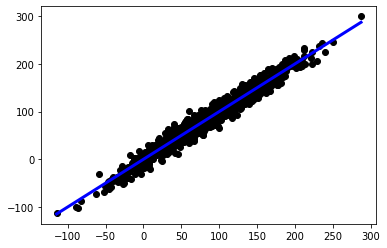

In [35]:
y_range = [np.min(y_pred), np.max(y_pred)]
plt.scatter(y_pred, df_test['y'],  color='black')
plt.plot(y_range, y_range, color='blue', linewidth=3)

plt.show()


In [36]:
from scipy.interpolate import interp1d

In [53]:
%%time

if len(feature_columns) == 1:
    train_sort_idx = np.argsort(df_train[feature_columns[0]])
    spline_model = interp1d(
        df_train.loc[train_sort_idx, feature_columns[0]], 
        df_train.loc[train_sort_idx, 'y'], 
        kind='linear',  # cubic, linear, nearest
        assume_sorted=True, 
        fill_value="extrapolate",
    )
else:
    from scipy.interpolate import griddata
    grid_x, grid_y = np.mgrid[0:1:complex(0,N_TRAIN), 0:1:complex(0,N_TRAIN)]
    points = df_train[feature_columns]
    values = df_train['y']
    spline_model = griddata(points, values, (grid_x, grid_y), method='linear')

    

CPU times: user 137 ms, sys: 17.7 ms, total: 155 ms
Wall time: 147 ms


In [62]:
grid_y

array([[0.      , 0.001001, 0.002002, ..., 0.997998, 0.998999, 1.      ],
       [0.      , 0.001001, 0.002002, ..., 0.997998, 0.998999, 1.      ],
       [0.      , 0.001001, 0.002002, ..., 0.997998, 0.998999, 1.      ],
       ...,
       [0.      , 0.001001, 0.002002, ..., 0.997998, 0.998999, 1.      ],
       [0.      , 0.001001, 0.002002, ..., 0.997998, 0.998999, 1.      ],
       [0.      , 0.001001, 0.002002, ..., 0.997998, 0.998999, 1.      ]])

In [59]:
if len(feature_columns) == 1:
    y_spline_pred = spline_model(df_test[feature_columns[0]])
    
    print("Linear regression RMSE", mean_squared_error(df_test['y'], y_pred, squared=False))
    print("Interpolation RMSE    ", mean_squared_error(df_test['y'], y_spline_pred, squared=False))

    plt.plot(
        df_train.loc[train_sort_idx, feature_columns[0]], 
        df_train.loc[train_sort_idx, 'y'], 
        'o', 
        df_train.loc[train_sort_idx, feature_columns[0]], 
        spline_model(df_train[feature_columns[0]])[train_sort_idx], 
        '-', 
        df_test[feature_columns[0]], 
        y_pred,
        '-',
    )
    plt.show()
    
    test_sort_idx = np.argsort(df_test[feature_columns[0]])
    plt.plot(
        df_test.loc[test_sort_idx, feature_columns[0]], 
        df_test.loc[test_sort_idx, 'y'], 
        'o', 
        df_test.loc[test_sort_idx, feature_columns[0]], 
        y_spline_pred[test_sort_idx], 
        '-', 
        df_test[feature_columns[0]], 
        y_pred,
        '-',
    )
    plt.show()
else:
    grid_x, grid_y = np.mgrid[0:1:complex(0,N_TEST), 0:1:complex(0,N_TEST)]
    points = df_test[feature_columns]
    values = df_test['y']
    y_spline_pred = spline_model(df_test[feature_columns])
    
    print("Linear regression RMSE", mean_squared_error(df_test['y'], y_pred, squared=False))
    print("Interpolation RMSE    ", mean_squared_error(df_test['y'], y_spline_pred, squared=False))

    #     plt.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin='lower')
#     plt.plot(points[:,0], points[:,1], 'k.', ms=1)
#     plt.title('Original')
#     plt.subplot(223)
    plt.imshow(grid_z1.T, extent=(0,1,0,1), origin='lower')
    plt.title('Linear')
    plt.gcf().set_size_inches(6, 6)
    plt.show()

    


Linear regression RMSE 12.012723276636397


ValueError: y_true and y_pred have different number of output (1!=2)

In [60]:
spline_model(df_test[feature_columns])

array([[52.48823518, 39.53717235],
       [-6.15987335,  4.81673761],
       [60.14680304, 12.16077733],
       ...,
       [32.57937975, 60.77879635],
       [38.11976537, 53.98309091],
       [26.62466557, 28.71282784]])

In [ ]:
if len(feature_columns) > 1:
